In [86]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.ticker as ticker


In [11]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [12]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [13]:
# strip spaces from column names
life_df.columns = life_df.columns.str.strip()

In [14]:
life_df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938,2938.000000,2938,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,...,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Ghana,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,...,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,NaN,4.613841,NaN,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,...,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,...,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2004.000000,NaN,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,...,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,NaN,2008.000000,NaN,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,...,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,NaN,2012.000000,NaN,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,...,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000


## Handling missing values

In [15]:
# percent of empty entries in each column
life_df.isnull().sum()/life_df.shape[0]*100

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
BMI                                 1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
HIV/AIDS                            0.000000
GDP                                15.248468
Population                         22.191967
thinness  1-19 years                1.157250
thinness 5-9 years                  1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

Checking column correlation matrix to see if missing values can be inferred with the help of other columns

In [16]:
corr = life_df.corr()
corr.style.background_gradient(cmap='RdBu_r')
# 'coolwarm' & 'BrBG' are other good diverging colormaps

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1,0.170033,-0.0790516,-0.0374149,-0.0529898,0.0314,0.104333,-0.082493,0.108974,-0.042937,0.0941584,0.0907401,0.134337,-0.139741,0.10162,0.0169692,-0.0478764,-0.0509291,0.243468,0.2094
Life expectancy,0.170033,1,-0.696359,-0.196557,0.404877,0.381864,0.256762,-0.157586,0.567694,-0.222529,0.465556,0.218086,0.479495,-0.556556,0.461455,-0.0215381,-0.477183,-0.471584,0.724776,0.751975
Adult Mortality,-0.0790516,-0.696359,1,0.078756,-0.195848,-0.24286,-0.162476,0.0311764,-0.387017,0.0941461,-0.274823,-0.115281,-0.275131,0.523821,-0.296049,-0.013647,0.302904,0.308457,-0.457626,-0.454612
infant deaths,-0.0374149,-0.196557,0.078756,1,-0.115638,-0.0856122,-0.223566,0.501128,-0.227279,0.996629,-0.170689,-0.128616,-0.175171,0.0252313,-0.108427,0.556801,0.465711,0.47135,-0.145139,-0.19372
Alcohol,-0.0529898,0.404877,-0.195848,-0.115638,1,0.341285,0.0875487,-0.0518267,0.330408,-0.11237,0.221734,0.296942,0.22202,-0.0488446,0.354712,-0.0352523,-0.428795,-0.417414,0.45004,0.547378
percentage expenditure,0.0314,0.381864,-0.24286,-0.0856122,0.341285,1,0.0162737,-0.0565957,0.2287,-0.0878523,0.147259,0.17442,0.143624,-0.0978568,0.899373,-0.0256619,-0.251369,-0.252905,0.381952,0.389687
Hepatitis B,0.104333,0.256762,-0.162476,-0.223566,0.0875487,0.0162737,1,-0.120529,0.15038,-0.233126,0.486171,0.0582803,0.611495,-0.112675,0.0839032,-0.123321,-0.120429,-0.12496,0.199549,0.231117
Measles,-0.082493,-0.157586,0.0311764,0.501128,-0.0518267,-0.0565957,-0.120529,1,-0.175977,0.507809,-0.136166,-0.106241,-0.141882,0.0308987,-0.0764661,0.265966,0.224808,0.221072,-0.129568,-0.137225
BMI,0.108974,0.567694,-0.387017,-0.227279,0.330408,0.2287,0.15038,-0.175977,1,-0.237669,0.284569,0.242503,0.283147,-0.243717,0.301557,-0.072301,-0.532025,-0.538911,0.508774,0.546961
under-five deaths,-0.042937,-0.222529,0.0941461,0.996629,-0.11237,-0.0878523,-0.233126,0.507809,-0.237669,1,-0.18872,-0.130148,-0.195668,0.0380615,-0.112081,0.544423,0.467789,0.472263,-0.163305,-0.209373


In [8]:
# Use linear regression to fill missing values

# save empty enteries stats
before_impute = (life_df.isnull().sum()/life_df.shape[0]*100).values

# for each target column with missing values, select columns with more than 0.4 absloute correlation
target_cols = life_df.columns[(life_df.isnull().sum()/life_df.shape[0]*100) > 0]

# intitalize LinearRegression function
linreg = LinearRegression()

for target_col in target_cols:
    cols_of_interest = corr.index[abs(corr[target_col]) > 0.4]

    # use linear regression to impute missing data in columns of interest
    data=life_df[cols_of_interest]

    # split data to proper format for testing and training
    x_train = data[ data[target_col].notnull()].drop(columns=target_col)
    y_train = data[ data[target_col].notnull()][target_col]
    x_test = data[ data[target_col].isnull()].drop(columns=target_col)
    y_test = data[ data[target_col].isnull()][target_col]
    
    # train
    linreg.fit(x_train, y_train)
    
    #predict
    pred = linreg.predict(x_test)
    
    # fill missing values based on prediction
    life_df[target_col][life_df[target_col].isnull()] = pred
    life_df = life_df.reset_index() # to deal with error from sklearn

# print percent of empty entries before and after imputation
after_impute = (life_df.isnull().sum()/life_df.shape[0]*100).values
impute_ind = (life_df.isnull().sum()/life_df.shape[0]*100).index
print('{0:<30}      {1:<12}      {2:<12}'.format('', 'before', 'after')) 
for row in zip(impute_ind, before_impute, after_impute):
    print('{0:<30}      {1:<15.3}      {2:<15.3}'.format(*row)) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Linear regression depends on other columns, which seem to contain na's themselves and therefore sklearn cannot complete the linear fitting. 

In [17]:
# using pandas interpolation function to fill missing values
fill_cols = life_df.columns[life_df.isnull().sum() > 0]
countries = life_df['Country'].unique()

# save empty enteries stats
before_inter = (life_df.isnull().sum()/life_df.shape[0]*100).values

for country in countries:
    life_df.loc[life_df['Country'] == country, fill_cols] = life_df.loc[life_df['Country'] == country, fill_cols].interpolate(method='linear', limit_direction='both')

# print percent of empty cells before and after imputation
after_inter = (life_df.isnull().sum()/life_df.shape[0]*100).values
inter_ind = (life_df.isnull().sum()/life_df.shape[0]*100).index
print('{0:<30}      {1:<12}      {2:<12}'.format('', 'before', 'after')) 
for row in zip(inter_ind, before_inter, after_inter):
    print('{0:<30}      {1:<15.3}      {2:<15.3}'.format(*row))   

                                    before            after       
Country                             0.0                  0.0            
Year                                0.0                  0.0            
Status                              0.0                  0.0            
Life expectancy                     0.34                 0.34           
Adult Mortality                     0.34                 0.34           
infant deaths                       0.0                  0.0            
Alcohol                             6.6                  0.579          
percentage expenditure              0.0                  0.0            
Hepatitis B                         18.8                 4.9            
Measles                             0.0                  0.0            
BMI                                 1.16                 1.16           
under-five deaths                   0.0                  0.0            
Polio                               0.647                

In [18]:
# drop empty rows that cannot be interpolated
life_df.dropna(inplace=True)
life_df.isnull().sum()/life_df.shape[0]*100

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
BMI                                0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
HIV/AIDS                           0.0
GDP                                0.0
Population                         0.0
thinness  1-19 years               0.0
thinness 5-9 years                 0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

In [19]:
life_df.describe(include='all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2128,2128.000000,2128,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,...,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2.128000e+03,2128.000000,2128.000000,2128.000000,2128.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Ghana,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1824,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.500000,NaN,68.139709,174.300282,35.902726,4.348240,640.072009,74.270207,2657.467105,...,80.335996,5.899370,80.477444,2.173637,5402.417263,1.339761e+07,5.107895,5.177538,0.607481,11.691823
std,NaN,4.610856,NaN,9.610700,129.759274,136.224732,3.998403,1710.798798,28.796545,11912.236064,...,24.494233,2.305911,24.478990,5.827273,11376.222749,6.315772e+07,4.711951,4.805378,0.203404,3.203263
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,2.000000,0.000000,...,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2003.750000,NaN,62.000000,76.000000,1.000000,0.590000,19.883256,64.000000,0.000000,...,74.000000,4.357500,76.000000,0.100000,393.276186,1.989615e+05,1.600000,1.600000,0.476750,9.800000
50%,NaN,2007.500000,NaN,69.950000,152.000000,4.000000,3.600000,83.677991,87.000000,20.000000,...,91.000000,5.790000,91.000000,0.100000,1353.159574,1.425337e+06,3.400000,3.400000,0.649500,11.900000
75%,NaN,2011.250000,NaN,74.800000,241.250000,24.000000,7.115000,431.365149,95.000000,459.250000,...,96.000000,7.390000,96.000000,1.300000,4494.285047,7.785482e+06,7.525000,7.600000,0.747000,13.800000


In [ ]:
# make histograms for all numerical variables and take care of outliers (log transform and test normality)
# Calculate correlation matrix (can this be color coded?)
#     corr = df.corr()
#     corr.style.background_gradient(cmap='coolwarm')
# PCA and PCA variable contribution to choose variables
# Choose longevity cutoff and make target categorial so LDA can be applied
# Visualization? scatter graphs where the longevity countris cluster by the dimensions? barplots where the
# longevity countries are significantly different than the rest of the population?

## Handling outliers

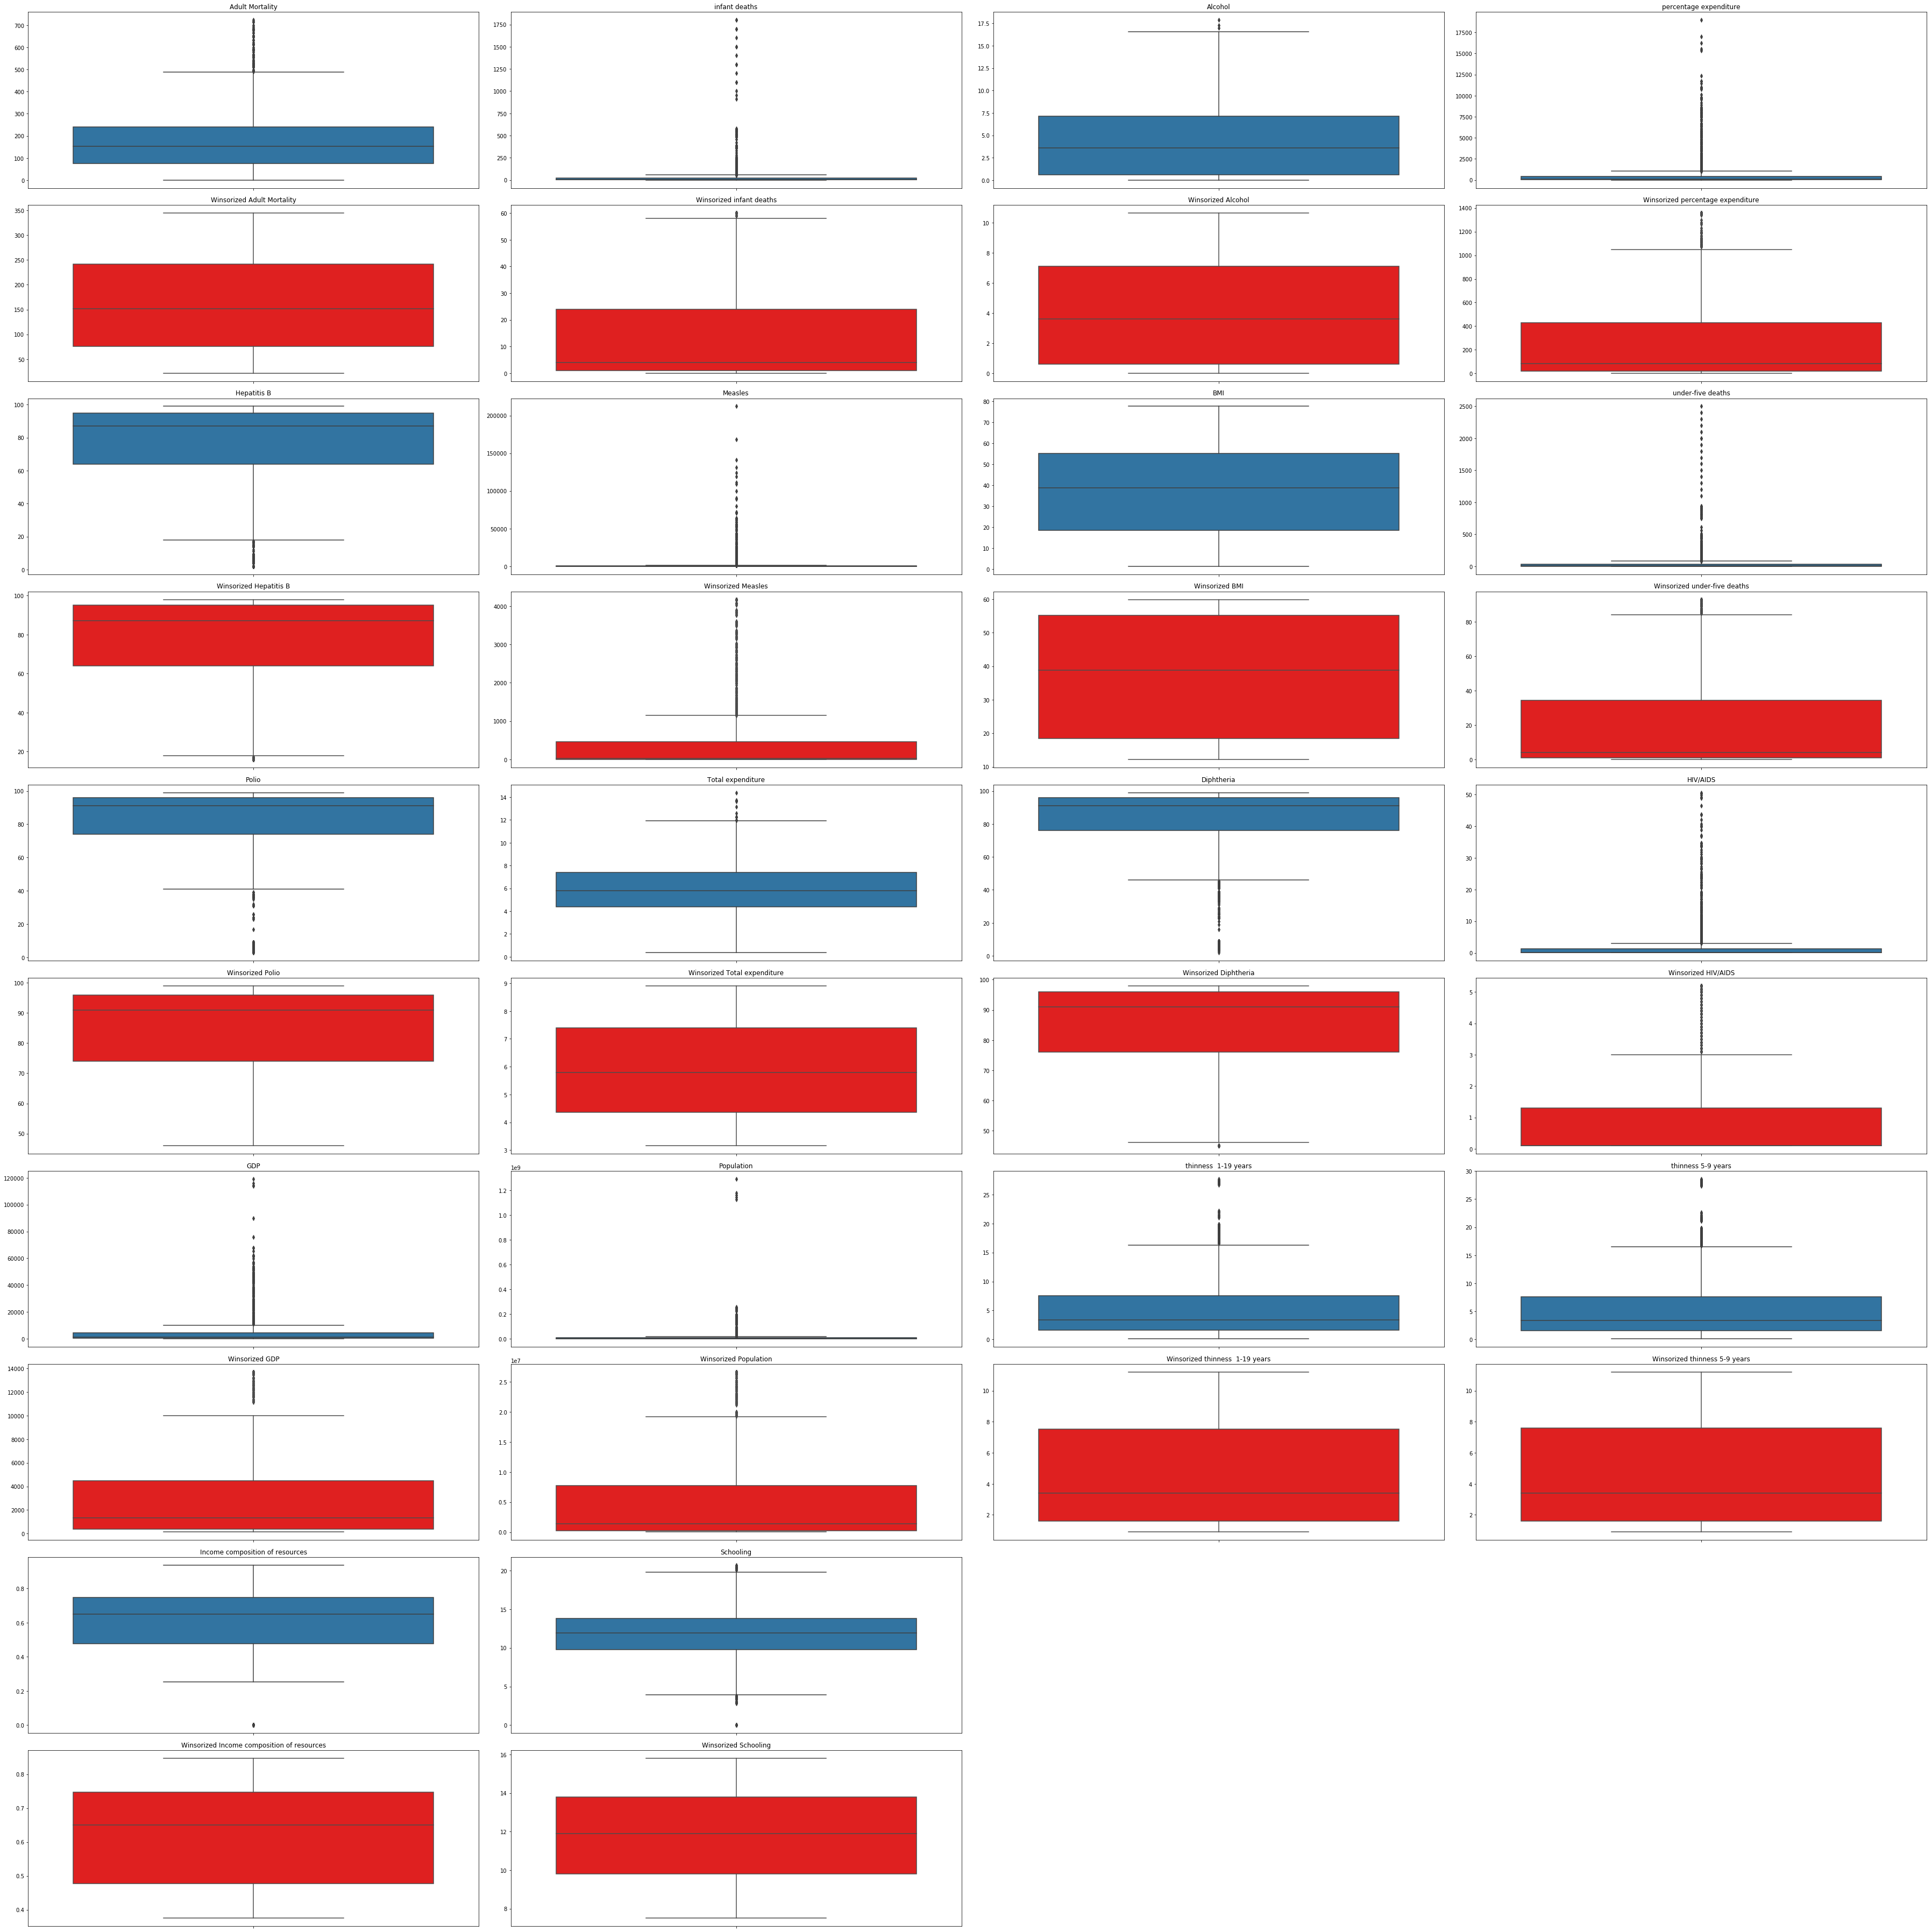

In [82]:
# apply two-way winsorization
adj_life_df = life_df.copy()
num_cols = adj_life_df.columns[4:] # all columns of interest (have to be numerical)

for col in num_cols:
    adj_life_df[col] = winsorize(adj_life_df[col], (0.10, 0.10))

# boxplot vaisualization of data before and after winsorization
plt.figure(figsize=(50, 50))

for i in range(1, len(num_cols)+1):
    
    # original data boxplots
    ind = 4*((i-1)//4)+i # for 1st row, 3rd row...
    plt.subplot(10, 4, ind)
    sns.boxplot(y=life_df[num_cols[i-1]])
    plt.title('{}'.format(num_cols[i-1]))
    plt.ylabel('')
    
    # log transformed data boxplots
    ind2 = 4*((i-1)//4+1)+i # for 2nd row, 4th row...
    plt.subplot(10, 4, ind2)
    sns.boxplot(y=adj_life_df[num_cols[i-1]], color='r')
    plt.title('Winsorized {}'.format(num_cols[i-1]))
    plt.ylabel('')


plt.tight_layout()
plt.show()

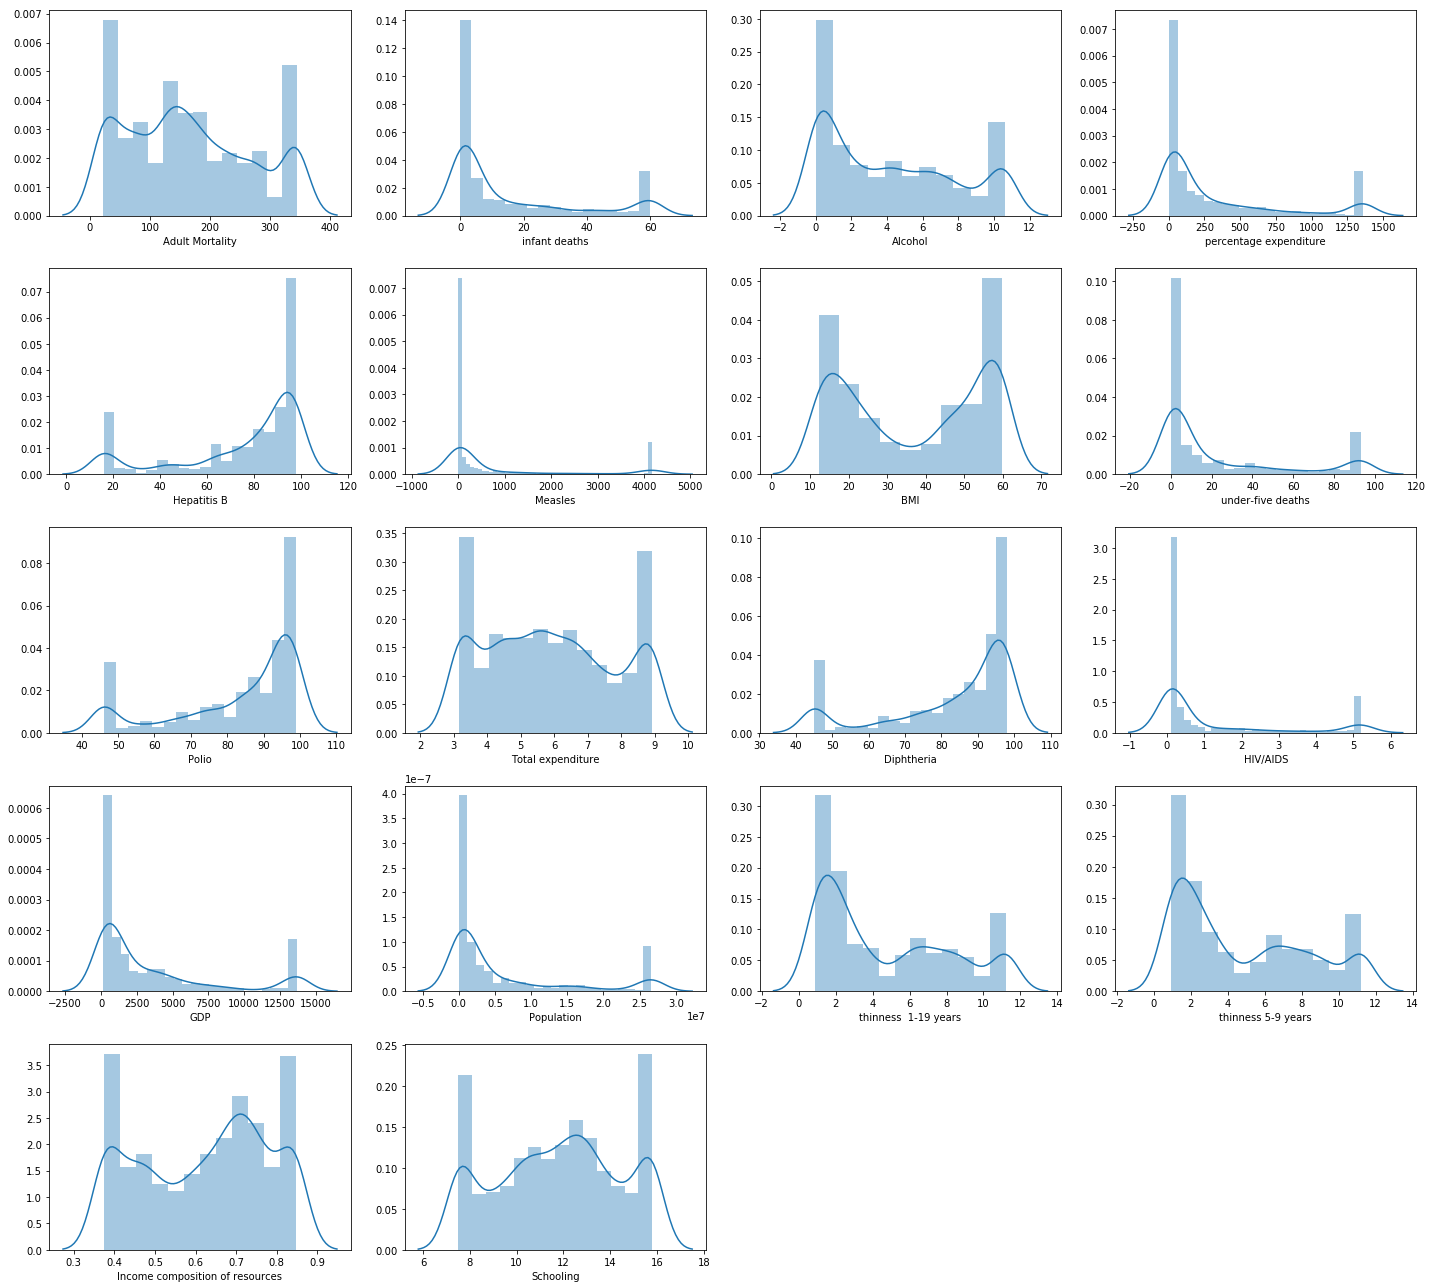

------------------------------------------------
Comparisons for variable: Adult Mortality
------------------------------------------------
Jarque-Bera test statistics on original data is 1.25e+02 and p value is 0.0
Normality test statistics on original data is 5.58e+02 and p value is 7.06e-122
Jarque-Bera test statistics on transformed data is 1.05e+02 and p value is 0.0
Normality test statistics on transformed data is 5.55e+02 and p value is 2.92e-121
------------------------------------------------
Comparisons for variable: infant deaths
------------------------------------------------
Jarque-Bera test statistics on original data is 5.65e+02 and p value is 0.0
Normality test statistics on original data is 3.56e+02 and p value is 4.8e-78
Jarque-Bera test statistics on transformed data is 5.45e+02 and p value is 0.0
Normality test statistics on transformed data is 3.62e+02 and p value is 1.99e-79
------------------------------------------------
Comparisons for variable: Alcohol
------

/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:902: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:2315: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/wesamazaizeh/miniconda3/lib/p

In [83]:
plt.figure(figsize=(20, 18))

for i in range(1, len(num_cols)+1):
    plt.subplot(5,4,i)
    sns.distplot(adj_life_df[num_cols[i-1]])

plt.tight_layout()
plt.show()

# Test distribution normality for numerical variables
for col in num_cols:
    print("------------------------------------------------")
    print("Comparisons for variable: {}".format(col))
    print("------------------------------------------------")
    try:
        boxcox_var,_ = boxcox(adj_life_df[col])
    except:
        data = adj_life_df[col].values
        posdata = data[data > 0]
        boxcox_var2, lam = boxcox(posdata)
        if lam > 0:
            boxcox_var = np.empty_like(data)
            boxcox_var[data > 0] = boxcox_var2
            boxcox_var[data == 0] = -1/lam
        else:
            print('\nBoxcox transofrmation cannot be applied to this dataset\n')
            continue
    jb_stats = jarque_bera(adj_life_df[col])
    norm_stats = normaltest(adj_life_df[col])
    print("Jarque-Bera test statistics on original data is {0:.3} and p value is {1:.3}".format(*jb_stats))
    print("Normality test statistics on original data is {0:.3} and p value is {1:.3}".format(*norm_stats))
    
    boxcox_jb_stats = jarque_bera(boxcox_var)
    boxcox_norm_stats = normaltest(boxcox_var)
    print("Jarque-Bera test statistics on transformed data is {0:.3} and p value is {1:.3}".format(*boxcox_jb_stats))
    print("Normality test statistics on transformed data is {0:.3} and p value is {1:.3}".format(*boxcox_norm_stats))

All feature are not normal even after boxcox transormation. Two-sided winsorization made data distribution less normal.

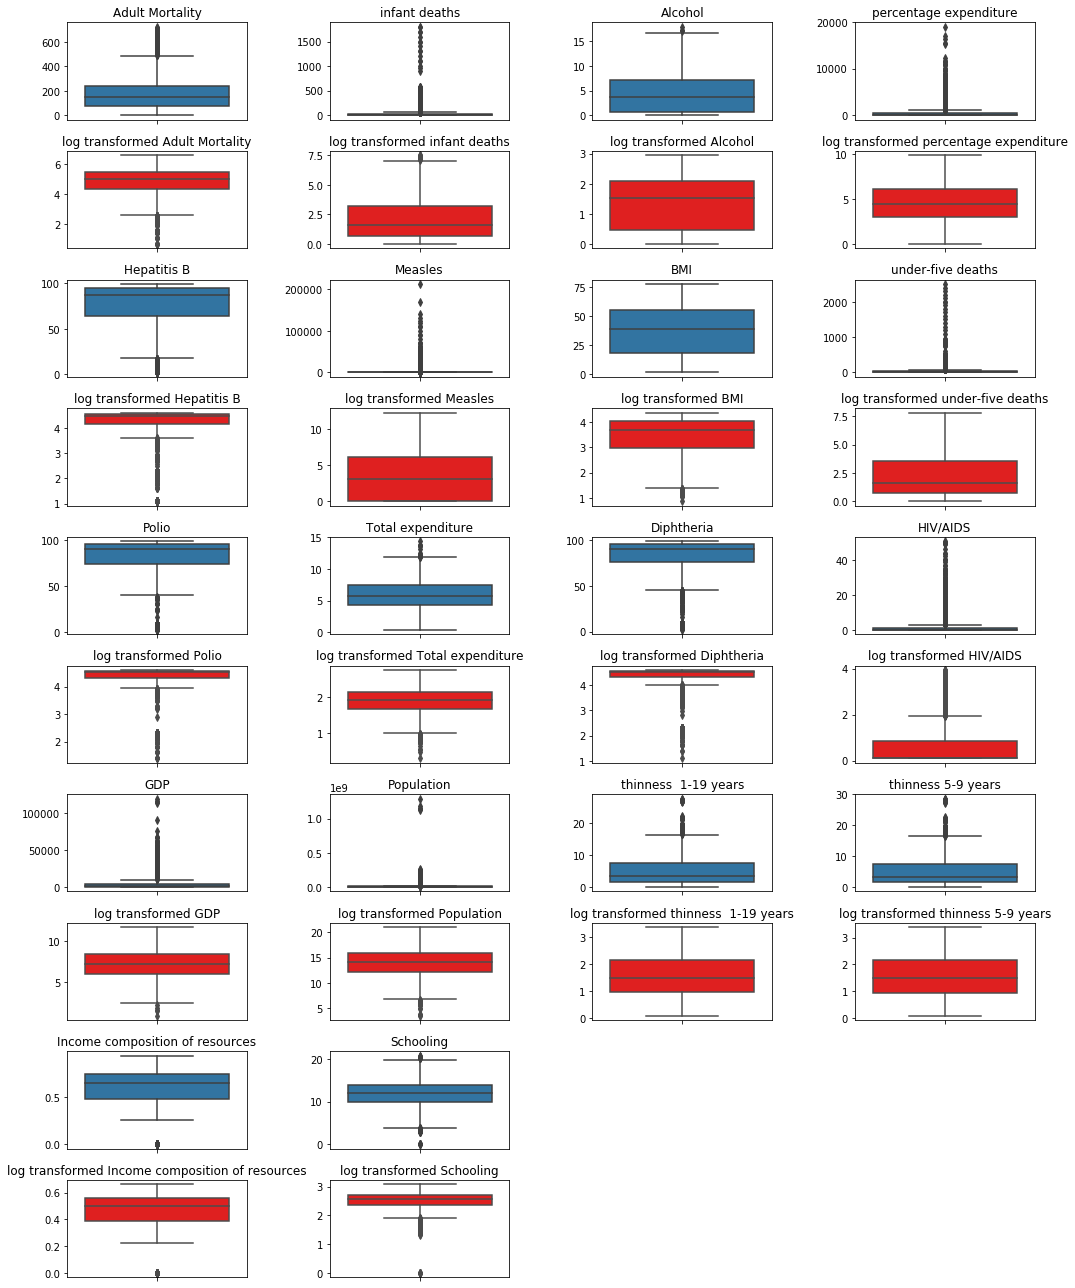

In [76]:
hist_cols = life_df.columns[4:]

plt.figure(figsize=(15, 18))

for i in range(1, len(hist_cols)+1):
    
    # original data boxplots
    ind = 4*((i-1)//4)+i # for 1st row, 3rd row...
    plt.subplot(10, 4, ind)
    sns.boxplot(y=life_df[hist_cols[i-1]])
    plt.title('{}'.format(hist_cols[i-1]))
    plt.ylabel('')
    
    # log transformed data boxplots
    ind2 = 4*((i-1)//4+1)+i # for 2nd row, 4th row...
    plt.subplot(10, 4, ind2)
    sns.boxplot(y=np.log(life_df[hist_cols[i-1]]+1), color='r')
    plt.title('log transformed {}'.format(hist_cols[i-1]))
    plt.ylabel('')


plt.tight_layout()
plt.show()

In [84]:
# check correlation matrix after standarization
corr = adj_life_df.corr()
corr.style.background_gradient(cmap='RdBu_r')


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Year,1,0.177657,-0.0438038,-0.0526474,-0.0840747,0.072798,0.247261,-0.163918,0.102065,-0.0601658,0.128021,0.058006,0.164052,-0.112456,0.17323,0.0428302,-0.0530076,-0.0520348,0.193327,0.205341
Life expectancy,0.177657,1,-0.620575,-0.516351,0.38643,0.516521,0.271589,-0.24479,0.630924,-0.540906,0.520337,0.253197,0.530866,-0.761422,0.537551,-0.00492505,-0.568596,-0.563133,0.842321,0.774018
Adult Mortality,-0.0438038,-0.620575,1,0.306569,-0.210108,-0.316087,-0.114334,0.10239,-0.409772,0.317182,-0.2818,-0.18135,-0.277269,0.496401,-0.320145,0.0164905,0.374441,0.383287,-0.515271,-0.456261
infant deaths,-0.0526474,-0.516351,0.306569,1,-0.287067,-0.337522,-0.191656,0.55032,-0.497228,0.993163,-0.373558,-0.218211,-0.365232,0.342726,-0.33763,0.404432,0.405768,0.427255,-0.504232,-0.534439
Alcohol,-0.0840747,0.38643,-0.210108,-0.287067,1,0.517783,0.112482,-0.127099,0.411319,-0.284142,0.282755,0.289258,0.285715,-0.0811095,0.533175,0.00626526,-0.425192,-0.413591,0.589157,0.593796
percentage expenditure,0.072798,0.516521,-0.316087,-0.337522,0.517783,1,0.0646506,-0.171939,0.407559,-0.33873,0.267487,0.311437,0.268386,-0.246574,0.866818,-0.0175614,-0.392225,-0.394495,0.588656,0.577197
Hepatitis B,0.247261,0.271589,-0.114334,-0.191656,0.112482,0.0646506,1,-0.208686,0.215063,-0.203378,0.531503,0.143399,0.604208,-0.261299,0.0951409,-0.0498264,-0.159594,-0.171577,0.279564,0.29038
Measles,-0.163918,-0.24479,0.10239,0.55032,-0.127099,-0.171939,-0.208686,1,-0.302825,0.552797,-0.248655,-0.206205,-0.238398,0.124695,-0.168452,0.268654,0.255212,0.264313,-0.233822,-0.288484
BMI,0.102065,0.630924,-0.409772,-0.497228,0.411319,0.407559,0.215063,-0.302825,1,-0.516672,0.344216,0.29192,0.341612,-0.448267,0.440859,-0.0422763,-0.635358,-0.646372,0.672116,0.653862
under-five deaths,-0.0601658,-0.540906,0.317182,0.993163,-0.284142,-0.33873,-0.203378,0.552797,-0.516672,1,-0.391705,-0.215199,-0.384723,0.366308,-0.341795,0.377473,0.415525,0.429911,-0.525712,-0.551013


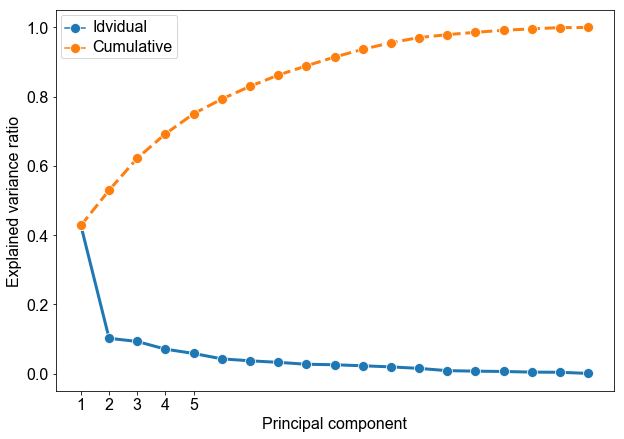

PCA 1st component explains 42.8% of the expenditure variance


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,PCA_1
Year,1,0.177657,-0.0438038,-0.0526474,-0.0840747,0.072798,0.247261,-0.163918,0.102065,-0.0601658,0.128021,0.058006,0.164052,-0.112456,0.17323,0.0428302,-0.0530076,-0.0520348,0.193327,0.205341,-0.161486
Life expectancy,0.177657,1,-0.620575,-0.516351,0.38643,0.516521,0.271589,-0.24479,0.630924,-0.540906,0.520337,0.253197,0.530866,-0.761422,0.537551,-0.00492505,-0.568596,-0.563133,0.842321,0.774018,-0.867151
Adult Mortality,-0.0438038,-0.620575,1,0.306569,-0.210108,-0.316087,-0.114334,0.10239,-0.409772,0.317182,-0.2818,-0.18135,-0.277269,0.496401,-0.320145,0.0164905,0.374441,0.383287,-0.515271,-0.456261,0.568845
infant deaths,-0.0526474,-0.516351,0.306569,1,-0.287067,-0.337522,-0.191656,0.55032,-0.497228,0.993163,-0.373558,-0.218211,-0.365232,0.342726,-0.33763,0.404432,0.405768,0.427255,-0.504232,-0.534439,0.695537
Alcohol,-0.0840747,0.38643,-0.210108,-0.287067,1,0.517783,0.112482,-0.127099,0.411319,-0.284142,0.282755,0.289258,0.285715,-0.0811095,0.533175,0.00626526,-0.425192,-0.413591,0.589157,0.593796,-0.580164
percentage expenditure,0.072798,0.516521,-0.316087,-0.337522,0.517783,1,0.0646506,-0.171939,0.407559,-0.33873,0.267487,0.311437,0.268386,-0.246574,0.866818,-0.0175614,-0.392225,-0.394495,0.588656,0.577197,-0.646699
Hepatitis B,0.247261,0.271589,-0.114334,-0.191656,0.112482,0.0646506,1,-0.208686,0.215063,-0.203378,0.531503,0.143399,0.604208,-0.261299,0.0951409,-0.0498264,-0.159594,-0.171577,0.279564,0.29038,-0.376693
Measles,-0.163918,-0.24479,0.10239,0.55032,-0.127099,-0.171939,-0.208686,1,-0.302825,0.552797,-0.248655,-0.206205,-0.238398,0.124695,-0.168452,0.268654,0.255212,0.264313,-0.233822,-0.288484,0.419676
BMI,0.102065,0.630924,-0.409772,-0.497228,0.411319,0.407559,0.215063,-0.302825,1,-0.516672,0.344216,0.29192,0.341612,-0.448267,0.440859,-0.0422763,-0.635358,-0.646372,0.672116,0.653862,-0.761593
under-five deaths,-0.0601658,-0.540906,0.317182,0.993163,-0.284142,-0.33873,-0.203378,0.552797,-0.516672,1,-0.391705,-0.215199,-0.384723,0.366308,-0.341795,0.377473,0.415525,0.429911,-0.525712,-0.551013,0.711011


In [109]:
# applying PCA

data = adj_life_df.iloc[:,3:].copy()
z_data = StandardScaler().fit_transform(data)
pca_res = PCA().fit(z_data)

plt.figure(figsize = (10,7))
sns.set_context( rc={'lines.markersize': 10, 'xtick.labelsize': 16, 'ytick.labelsize': 16}) # override marker and ticklabel size
g = sns.lineplot(y=pca_res.explained_variance_ratio_, x=list(range(1,len(pca_res.explained_variance_ratio_)+1)), marker="o", label='Idvidual')
sns.lineplot(y=pca_res.explained_variance_ratio_.cumsum(), x=list(range(1,len(pca_res.explained_variance_ratio_)+1)), marker="o", label='Cumulative')
sns.set_style('darkgrid')
plt.setp(g.lines,linewidth=3) # for line width
g.lines[1].set_linestyle("--") # for line style
plt.setp(g.get_legend().get_texts(), fontsize='16') # for legend text
plt.xlabel('Principal component', fontsize='16') # x-axis label
plt.ylabel('Explained variance ratio', fontsize='16') # y-axis label
g.set(xticks=list(range(1,6)))
plt.show()

print('PCA 1st component explains {:.3}% of the expenditure variance'.format(pca_res.explained_variance_ratio_[0]*100))

# check correlation with 1st principal component with rest of features
adj_life_df['PCA_1'] = PCA(n_components=1).fit_transform(z_data)
corr = adj_life_df.corr()
corr.style.background_gradient(cmap='RdBu_r')


/Users/wesamazaizeh/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


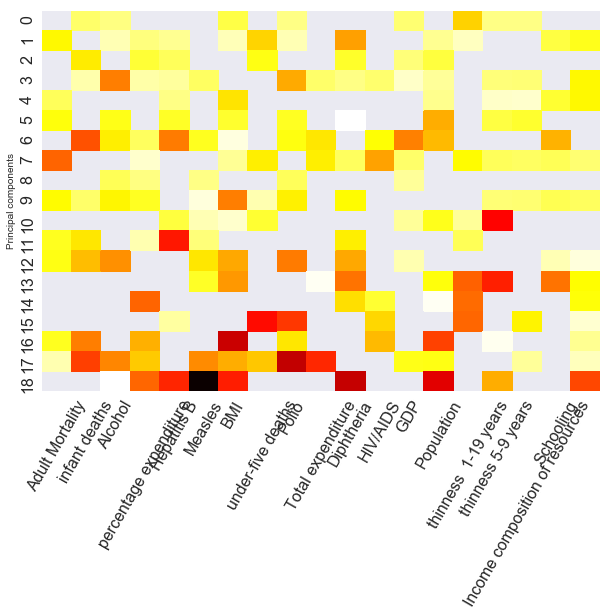

In [110]:
# heatmap of variables vs 1st principal components
fig, ax = plt.subplots(figsize=(10,7)) 
sns.set_context(rc={'axes.labelsize':16})
sns.heatmap(np.log(pca_res.inverse_transform(np.eye(data.shape[1]))), cmap="hot", cbar=False)
ax.set_xticklabels(num_cols) # set x-ticks labels
plt.xticks(rotation=60) # rotate x-tixks so they fit next to each other
plt.ylabel('Principal components') # y-axis label
plt.show()